# Plane wave angle dependence on frequency

## Theoretical background

Tidy3D provides two methods for simulating angled plane waves:
1. Fixed in-plane k vector mode, and
2. Fixed angle mode.
   
Both methods produce the same results at the central source frequency, but their behavior away from the central frequency differs significantly and it is important to understand the differences between the two approaches.

The first method is based on injecting an angled plane wave source and imposing the Bloch boundary conditions on periodic domain edges (see tutorial on boundary conditions for details). Fields that satisfy Bloch boundary conditions undergo a change of constant factor across periodic boudnaries. For example, if a plane wave with frequency $f_0$ and angle $\theta_0$ with the $x$ axis is propagating along axis $z$, then the fields will differ by a factor of $\exp(-i \sin(\theta_0) f_0 L_x)$ between opposites edges in the $x$ direction. If we consider another plane wave with the same angle but a different frequency $f_1$, then this second plane wave would undergo a different phase difference of $\exp(-i \sin(\theta_0) f_1 L_x)$. However, the FDTD method performs evolution of time domain fields, which consist of a continious spectrum of waves in a certain frequency range, and only single phase factor can be applied at periodic Bloch boundaries. Typically, this factor is selected to correspond to the central frequency of the injected plane wave. Which means that only fields at the central frequency would satisfy the desired angle. Angles of frequency domain fields computed for wavelengths away from the central one will differ from $\theta_0$. By performing simple calculations it is easy to show that the field angle dependence on frequency is $\theta_{actual}(f) = \arcsin(\sin(\theta_0) \frac{f_0}{f})$. 

A simple code below visualizes this dependece in case of $\theta_0 = 30$ deg.

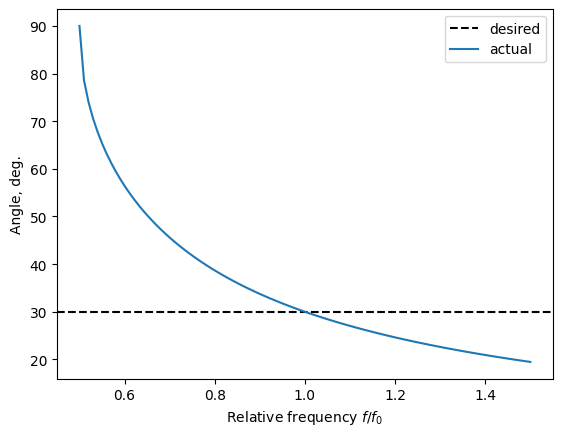

In [1]:
# Visualization
def plot_theta_actual(theta_deg):
    import numpy as np
    from matplotlib import pyplot as plt
    theta = theta_deg / 180 * np.pi
    freq_ratio = np.linspace(0.5, 1.5, 100)
    theta_actual = 180 / np.pi * np.arcsin(np.sin(theta) / freq_ratio)
    plt.axhline(y=theta * 180 / np.pi, color='k', ls="--")
    plt.plot(freq_ratio, theta_actual)
    plt.legend(["desired", "actual"])
    plt.ylabel("Angle, deg.")
    plt.xlabel(f"Relative frequency $f/f_0$")
    plt.show()

plot_theta_actual(theta_deg=30)

The second approach avoids the issue of angular frequency dependency by modifying the governing Maxwell equations to include the correct phase difference for all frequencies. The resulting equations to be solved in fact represent propagation of normally incident plane wave but with additional coupling factors. These coupling terms increase the computaional complexity, which leads to the following two disadvantages  of the second approach compared to the first one.

#### 1. Simulation Cost

First of all, it increases the cost of running a simulation: the fixed angle technique could lead to a significant increase of simulation cost. This increase depends depends on the angle of propagation plane wave. For example, for a plane wave inclined at angle $\theta=5$ degrees the simulation cost increase compared to the fixed in-plane k simulation would be approximately a factor of 2, while for a plane wave angled at $\theta = 50$ degrees such an increase would be approximately a factor of 4. The user is encouraged to use `web.estimate()` cost estimation function before submitting simulation for running.

Despite increased simulation costs, the fixed angle technique can significantly outperform the fixed in plane k technique if many frequency points are of interest. For example, to accurately compute scattering and transmission of an inclined plane wave at a given angle of $\theta = 50$ deg. and at one hundred frequency points it would cost about 100 / 4 = 25 times more for the fixed in plane k vector method, because it would require to perform 100 different simulations for each frequency of interest.

#### 2. Stability

Another disadvantage of the fixed angle technique that couple from additional coupling terms, is more frequent divergence issues. In most cases this could be alleviated by either reducing the `courant` factor or switching absorbing boundary conditions in the propagation direction to adiabatic [Absorber](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Absorber.html). Overall, the user should exercise more caution when dealing with fixed angle simulations.

### Tidy3D Python API

In Tidy3D Python API the switch between the two different techniques is simply accomplished by changing the field `angular_spec` of a [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source from [FixedInPlaneKSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FixedInPlaneKSpec.html) (default) to [FixedAngleSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FixedAngleSpec.html). Additionally, for the fixed in plane k simulations [Bloch boundary conditions](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.BlochBoundary.html) must be correctly set up, while for the fixed angle simulations periodic boundary conditions are simply set to [Periodic](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Periodic.html).

## Demonstration: transmission through a dispersive stack.

Let us know demonstrate the application of these two techniques. We will revisit [the example of a plane wave transmission through a layered stack of dispersive materials](https://www.flexcompute.com/tidy3d/examples/notebooks/Dispersion/). This example admits an analytical solution using the transfer matrix method, which makes it easy to benchmark the accuracy of both methods.

### Simulation Setup

Import Tidy3D and other packages.

In [2]:
import tidy3d as td
import numpy as np
from matplotlib import pyplot as plt
from tidy3d import web

Define angles of the injected plane wave.

In [3]:
# Source angles
theta_deg = 20
phi_deg = 30
pol_deg = 40

# convert to radians
theta = theta_deg * np.pi / 180
phi = phi_deg * np.pi / 180
pol = pol_deg * np.pi / 180

Define the frequency range of interest.

In [4]:
# Wavelength and frequency range
lambda_range = (0.5, 1.5)
lam0 = np.sum(lambda_range) / 2
freq_range = (td.constants.C_0 / lambda_range[1], td.constants.C_0 / lambda_range[0])
Nfreq = 333

# frequencies and wavelengths of monitor
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
freq0 = monitor_freqs[Nfreq // 2]
freqw = 0.3 * (freq_range[1] - freq_range[0])

We will consider a stack of 4 layers with thicknesses 0.5, 0.2, 0.4, and 0.3 $\mu m$.

In [5]:
# Thicknesses of slabs
t_slabs = [0.5, 0.2, 0.4, 0.3]  # um

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (0.2, 1, 4 * spacing + sum(t_slabs))

Layers are made or dispersive and non-dispersive materials.

In [6]:
# Materials
# simple dieletric, background material
mat0 = td.Medium(permittivity=1)

# simple, lossy material
mat1 = td.Medium(permittivity=4.0, conductivity=0.01)

# active material with n & k values at a specified frequency or wavelength
mat2 = td.Medium.from_nk(n=3.0, k=0.1, freq=freq0)

# weakly dispersive material defined by dn_dwvl at a given frequency
mat3 = td.Sellmeier.from_dispersion(n=2.0, dn_dwvl=-0.1, freq=freq0)

# dispersive material from tidy3d library
mat4 = td.material_library["BK7"]["Zemax"]

# put all together
mat_slabs = [mat1, mat2, mat3, mat4]

Given the defined layer thicknesses and material definition, programmatically create corresponding Tidy3D structures.

In [7]:
# Structures
slabs = []
slab_position = -Lz / 2 + 2 * spacing
for t, mat in zip(t_slabs, mat_slabs):
    slab = td.Structure(
        geometry=td.Box(
            center=(0, 0, slab_position + t / 2),
            size=(td.inf, td.inf, t),
        ),
        medium=mat,
    )
    slabs.append(slab)
    slab_position += t

To analyze the simulation results we will record the total transmitted flux. Additionally, for visual comparison we will record the actual field distributions at three different frequency points: the central frequency of the source and the end points of the frequency range defined above. 

In [8]:
# Monitors
monitor = td.FluxMonitor(
    center=(0, 0, Lz / 2 - spacing),
    size=(td.inf, td.inf, 0),
    freqs=monitor_freqs,
    name="flux",
)

field_freqs = [freq_range[0], freq0, freq_range[1]]
field_yz = td.FieldMonitor(
    center=(0, 0, 0),
    size=(0, td.inf, td.inf),
    freqs=field_freqs,
    name="field_yz"
)

As it was mentioned in the introduction, when setting up a fixed in-plane k simulation, one must select the corresponding `angular_spec` in a [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source definition, and set up compatible periodic Bloch boundary conditions.

Note that [FixedInPlaneKSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FixedInPlaneKSpec.html) is the default value for field `angular_spec`. Thus, in the code below one can omit explicity setting this field.

 source from (default) to . Additionally, for the fixed in plane k simulations [Bloch boundary conditions](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.BlochBoundary.html) must be correctly set up, while for the fixed angle simulations periodic boundary conditions are simply set to [Periodic](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Periodic.html).

In [9]:
# Sources
source_fixed_k = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz / 2 + spacing),
    direction="+",
    angle_theta=theta,
    angle_phi=phi,
    pol_angle=pol,
    angular_spec=td.FixedInPlaneKSpec(),
)

# Boundary conditions
boundary_spec_fixed_k = td.BoundarySpec(
    x=td.Boundary.bloch_from_source(axis=0, source=source_fixed_k, domain_size=sim_size[0], medium=mat0),
    y=td.Boundary.bloch_from_source(axis=1, source=source_fixed_k, domain_size=sim_size[1], medium=mat0),
    z=td.Boundary.pml(),
)

When setting up a fixed angle simulation one needs to set `angular_spec` to [FixedAngleSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FixedAngleSpec.html) in the source definition, and apply simple periodic boundary conditions.

In [10]:
# Sources
source_fixed_angle = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz / 2 + spacing),
    direction="+",
    angle_theta=theta,
    angle_phi=phi,
    pol_angle=pol,
    angular_spec=td.FixedAngleSpec(),
)

# Boundary conditions
boundary_spec_fixed_angle = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary.pml(),
)

Define final specifications for both a fixed in-plane k simulation and a fixed angle one. 

In [11]:
# Grid resolution (min steps per wavelength in a material)
res = 40

# Simulation time
t_stop = 100 / freq0

# Simulations
sim_fixed_k = td.Simulation(
    medium=mat0,
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=res),
    structures=slabs,
    sources=[source_fixed_k],
    monitors=[monitor, field_yz],
    run_time=t_stop,
    boundary_spec=boundary_spec_fixed_k,
    shutoff=1e-7,
)

sim_fixed_angle = sim_fixed_k.updated_copy(sources=[source_fixed_angle], boundary_spec=boundary_spec_fixed_angle)

### Running simulations

In [12]:
task_fixed_angle = web.upload(simulation=sim_fixed_angle, task_name="fixed_angle")
task_fixed_k = web.upload(simulation=sim_fixed_k, task_name="fixed_k")

11:14:20 CST Created task 'fixed_angle' with task_id                            
             'fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=175267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=880643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2\taskId]8;;\]8;id=175267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2\=]8;;\]8;id=731126;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2\fdve]8;;\]8;id=175267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2\-85ae46e1-12b]8;;\
             ]8;id=175267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85ae46e1-12be-41c2-9048-9b9d5a8f9dd2\e-41c2-9048-9b9d5a8f9dd2']8;;\.

Output()

11:14:21 CST Created task 'fixed_k' with task_id                                
             'fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=502121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=418115;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c\taskId]8;;\]8;id=502121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c\=]8;;\]8;id=28765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c\fdve]8;;\]8;id=502121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c\-ef15ab4d-ab5]8;;\
             ]8;id=502121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef15ab4d-ab54-4897-97e8-c2185ea3799c\4-4897-97e8-c2185ea3799c']8;;\.

Output()

Before submitting the simulations to our servers for solving, let us compare the estimated simulation costs.

In [13]:
cost_fixed_angle = web.estimate_cost(task_id=task_fixed_angle, solver_version="fixed-angle-rebase-0.0.1")
cost_fixed_k = web.estimate_cost(task_id=task_fixed_k, solver_version="fixed-angle-rebase-0.0.1") 

11:14:27 CST Maximum FlexCredit cost: 0.089. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

11:14:34 CST Maximum FlexCredit cost: 0.042. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Thus, in this particular situation the fixed angle simulation would be approximately charged more by a factor of

In [14]:
cost_fixed_angle / cost_fixed_k

2.1017122517484346

Submit and run simulations as usual.

In [15]:
# Run simulations
sim_data_fixed_angle = web.run(simulation=sim_fixed_angle, task_name="fixed_angle", solver_version="fixed-angle-rebase-0.0.1")
sim_data_fixed_k = web.run(simulation=sim_fixed_k, task_name="fixed_k", solver_version="fixed-angle-rebase-0.0.1")

             Created task 'fixed_angle' with task_id                            
             'fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=662576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=502691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\taskId]8;;\]8;id=662576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\=]8;;\]8;id=289592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\fdve]8;;\]8;id=662576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\-ba0380af-846]8;;\
             ]8;id=662576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\0-4ec3-bf3f-658c78ee484f']8;;\.

Output()

11:14:35 CST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:14:59 CST status = preprocess

11:15:01 CST Maximum FlexCredit cost: 0.089. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:15:10 CST early shutoff detected at 28%, exiting.

             status = postprocess

Output()

11:15:15 CST status = success

11:15:16 CST View simulation result at                                          
             ]8;id=725923;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=319224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\taskId]8;;\]8;id=725923;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\=]8;;\]8;id=372437;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\fdve]8;;\]8;id=725923;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\-ba0380af-846]8;;\
             ]8;id=725923;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba0380af-8460-4ec3-bf3f-658c78ee484f\0-4ec3-bf3f-658c78ee484f']8;;\.

Output()

11:15:20 CST loading simulation from simulation_data.hdf5

             Created task 'fixed_k' with task_id                                
             'fdve-aa3ce718-7225-4204-b637-50d73ecfc35e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=192501;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=557582;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\taskId]8;;\]8;id=192501;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\=]8;;\]8;id=46141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\fdve]8;;\]8;id=192501;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\-aa3ce718-722]8;;\
             ]8;id=192501;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\5-4204-b637-50d73ecfc35e']8;;\.

Output()

11:15:21 CST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:15:46 CST status = preprocess

11:15:47 CST Maximum FlexCredit cost: 0.042. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:16:01 CST status = postprocess

Output()

11:16:03 CST status = success

             View simulation result at                                          
             ]8;id=848502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=307633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\taskId]8;;\]8;id=848502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\=]8;;\]8;id=186802;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\fdve]8;;\]8;id=848502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\-aa3ce718-722]8;;\
             ]8;id=848502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa3ce718-7225-4204-b637-50d73ecfc35e\5-4204-b637-50d73ecfc35e']8;;\.

Output()

11:16:06 CST loading simulation from simulation_data.hdf5

             WARNING: Simulation final field decay value of 4.24e-07 is greater 
             than the simulation shutoff threshold of 1e-07. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

In addition, we will submit and run the exactly same simulation setups but with no structures included. This is done to obtain the precise amounts of power injected at all frequencies (recall that the injected power might slightly deviate from the intended value away from the central frequency due to numerical discretizations).

In [16]:
sim_data_fixed_angle_norm = web.run(simulation=sim_fixed_angle.updated_copy(structures=[]), task_name="fixed_angle_norm", solver_version="fixed-angle-rebase-0.0.1")
sim_data_fixed_k_norm = web.run(simulation=sim_fixed_k.updated_copy(structures=[]), task_name="fixed_k_norm", solver_version="fixed-angle-rebase-0.0.1")

             Created task 'fixed_angle_norm' with task_id                       
             'fdve-87956b4d-3347-46ab-a072-d7f83826f508' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=876595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=186171;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\taskId]8;;\]8;id=876595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\=]8;;\]8;id=18038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\fdve]8;;\]8;id=876595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\-87956b4d-334]8;;\
             ]8;id=876595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\7-46ab-a072-d7f83826f508']8;;\.

Output()

11:16:07 CST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:16:28 CST status = preprocess

11:16:30 CST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:16:34 CST early shutoff detected at 16%, exiting.

             status = postprocess

Output()

11:16:36 CST status = success

11:16:37 CST View simulation result at                                          
             ]8;id=580246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=764689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\taskId]8;;\]8;id=580246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\=]8;;\]8;id=549809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\fdve]8;;\]8;id=580246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\-87956b4d-334]8;;\
             ]8;id=580246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-87956b4d-3347-46ab-a072-d7f83826f508\7-46ab-a072-d7f83826f508']8;;\.

Output()

11:16:39 CST loading simulation from simulation_data.hdf5

             Created task 'fixed_k_norm' with task_id                           
             'fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=60423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=7676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\taskId]8;;\]8;id=60423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\=]8;;\]8;id=277293;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\fdve]8;;\]8;id=60423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\-ddf67d76-66b]8;;\
             ]8;id=60423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\d-47c2-9391-244448a0ef6c']8;;\.

Output()

11:16:40 CST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:17:05 CST status = preprocess

11:17:06 CST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:17:11 CST status = postprocess

Output()

11:17:13 CST status = success

             View simulation result at                                          
             ]8;id=330652;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=350997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\taskId]8;;\]8;id=330652;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\=]8;;\]8;id=667869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\fdve]8;;\]8;id=330652;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\-ddf67d76-66b]8;;\
             ]8;id=330652;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ddf67d76-66bd-47c2-9391-244448a0ef6c\d-47c2-9391-244448a0ef6c']8;;\.

Output()

11:17:15 CST loading simulation from simulation_data.hdf5

             WARNING: Simulation final field decay value of 1.66e-05 is greater 
             than the simulation shutoff threshold of 1e-07. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

### Simulation results analysis

We start analysis of simulation resutls with a visual inspection of field distributions recorded at three different frequencies. In the code below we plot the fixed in-plane k simulation results in the top row and the fixed angle simulation results in the second row.

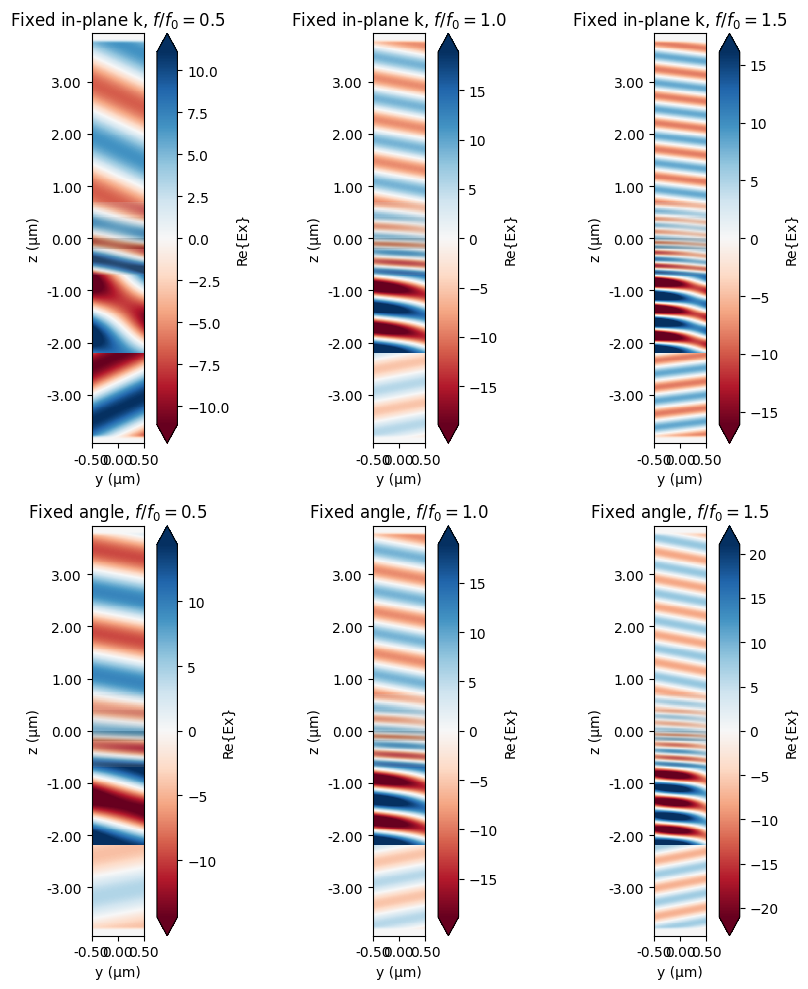

In [17]:
# Visualization
num_plots = len(field_freqs)
_, ax = plt.subplots(2, num_plots, figsize=(3 * num_plots, 10))

for ind in range(num_plots):
    sim_data_fixed_k.plot_field("field_yz", "Ex", "real", f=field_freqs[ind], ax=ax[0, ind])
    sim_data_fixed_angle.plot_field("field_yz", "Ex", "real", f=field_freqs[ind], ax=ax[1, ind])
    ax[0, ind].set_title(fr"Fixed in-plane k, $f/f_0 = {field_freqs[ind] / freq0}$")
    ax[1, ind].set_title(fr"Fixed angle, $f/f_0 = {field_freqs[ind] / freq0}$")
    
plt.tight_layout()
plt.show()


As one can see, in the fixed in-plane k case the angle of propagating plane wave changes significantly from one frequency point to another one. While in the fixed angle case the simulated plane wave propagation is performed for the same angle.

Now we perform a quantative analysis by comparing simulation results for the transmission flux to values obtained by the Transfer Matrix Method. The code below computes expected transmission fluxes using `tmm` package.

In [18]:
# Compare to TMM
import tmm

# prepare list of thicknesses including air boundaries
d_list = [np.inf] + t_slabs + [np.inf]

# convert the complex permittivities at each frequency to refractive indices
n_list0 = np.sqrt(mat0.eps_model(monitor_freqs))
n_list1 = np.sqrt(mat_slabs[0].eps_model(monitor_freqs))
n_list2 = np.sqrt(mat_slabs[1].eps_model(monitor_freqs))
n_list3 = np.sqrt(mat_slabs[2].eps_model(monitor_freqs))
n_list4 = np.sqrt(mat_slabs[3].eps_model(monitor_freqs))

# loop through wavelength and record TMM computed transmission
transmission_tmm_fixed_k = []
transmission_tmm_fixed_angle = []
for i, lam in enumerate(monitor_lambdas):
    theta_fixed_k = np.arcsin(np.sin(theta) * lam * freq0 / td.C_0)

    # create list of refractive index at this wavelength including outer material (air)
    n_list = [n_list0[i], n_list1[i], n_list2[i], n_list3[i], n_list4[i], n_list0[i]]

    # get transmission for fixed angle
    T = tmm.coh_tmm("p", n_list, d_list, theta, lam)["T"] * np.cos(pol) ** 2 + tmm.coh_tmm("s", n_list, d_list, theta, lam)["T"] * np.sin(pol) ** 2
    transmission_tmm_fixed_angle.append(T)
    
    # get transmission for fixed in-plane k
    T = tmm.coh_tmm("p", n_list, d_list, theta_fixed_k, lam)["T"] * np.cos(pol) ** 2 + tmm.coh_tmm("s", n_list, d_list, theta_fixed_k, lam)["T"] * np.sin(pol) ** 2
    transmission_tmm_fixed_k.append(T)

These values correspond to the data record by the flux monitors. Note that for obtaining accurate results we normalize simulated transmission values by the actual injected power.

In [19]:
# Normalize transmission flux
normalized_transmission_fixed_angle = sim_data_fixed_angle["flux"].flux / sim_data_fixed_angle_norm["flux"].flux
normalized_transmission_fixed_k = sim_data_fixed_k["flux"].flux / sim_data_fixed_k_norm["flux"].flux

The code below plot the comparison between the TMM results and the Tidy3D simulation results.

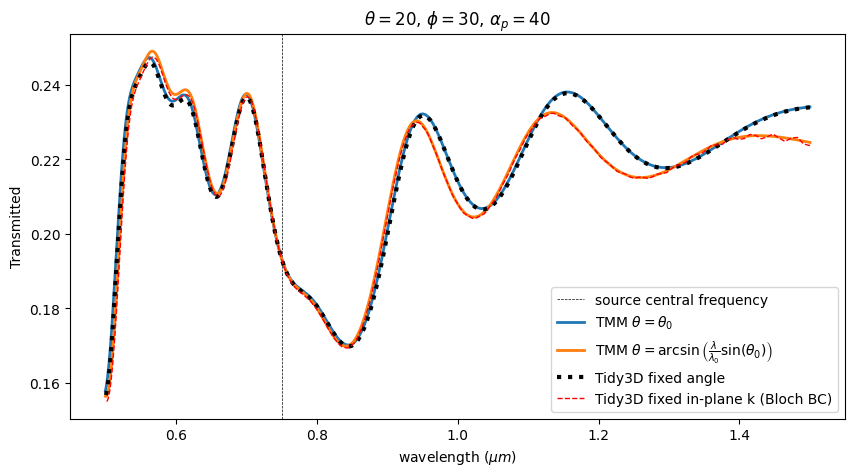

In [20]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.axvline(x=td.C_0 / freq0, label="source central frequency", color="k", ls="--", lw=0.5)
ax.plot(monitor_lambdas, transmission_tmm_fixed_angle, label=r"TMM $\theta = \theta_0$", lw=2)
ax.plot(monitor_lambdas, transmission_tmm_fixed_k, label=r"TMM $\theta = \arcsin\left(\frac{\lambda}{\lambda_0} \sin(\theta_0) \right)$", lw=2)
ax.plot(monitor_lambdas, normalized_transmission_fixed_angle, "k:", lw=3, label="Tidy3D fixed angle")
ax.plot(monitor_lambdas, normalized_transmission_fixed_k, "r--", lw=1, label="Tidy3D fixed in-plane k (Bloch BC)")
ax.set_xlabel("wavelength ($\mu m$)")
ax.set_ylabel("Transmitted")
ax.set_title(fr"$\theta = {theta_deg}$, $\phi = {phi_deg}$, $\alpha_p = {pol_deg}$")
ax.legend()
plt.show()

As expected the fixed in-plane k and fixed angle results coincide near the central frequency, but follow different frequency dependencies away from it. 